In [2]:
# Jupter (python) notebook that replicates Figures 1-2
# of "Estimating Idiosyncratic Price Setting Behavior with Machine Learning"
# Michael Munsell, Brandeis University (October 2018)

#Import required libraries
import os
import numpy as np
import pandas as pd
from sklearn import linear_model

#Pathway fundamentals
pd.options.display.max_rows = 1000
working_dir = os.getcwd()
data_path = os.path.join(working_dir,"..","data/expanded")

#Get list of all the file names for category-level data
filenames = []
for dirName, subdirList, fileList in os.walk(data_path):
    for fname in fileList:
        filenames.append(os.path.join(dirName,fname))

filenames = filenames[:-4]

categories = ['Bread and cereals','Meat','Fish and seafood',\
              'Milk, cheese and eggs','Oils and fats','Fruit','Vegetables',\
              'Sugar, jam, etc.']

#Set up in-line charts
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Define Linear variables
lin_reg_vars = ['sqrt_duration_lag', 'inv_sqrt_duration_lag', 'chg_p_lag',\
                 'd0_lag', 'd1_lag', 'd2_lag', 'd3_lag', 'd4_lag','d5_lag',\
                'd6_lag','d7_lag','d8_lag','d9_lag','d10_lag','d11_lag','d12_lag',\
                'd13_lag','d14_lag','d15_lag','d16_lag', \
                'd17_lag','d18_lag','d19_lag','d20_lag','d21_lag','d22_lag','d23_lag']


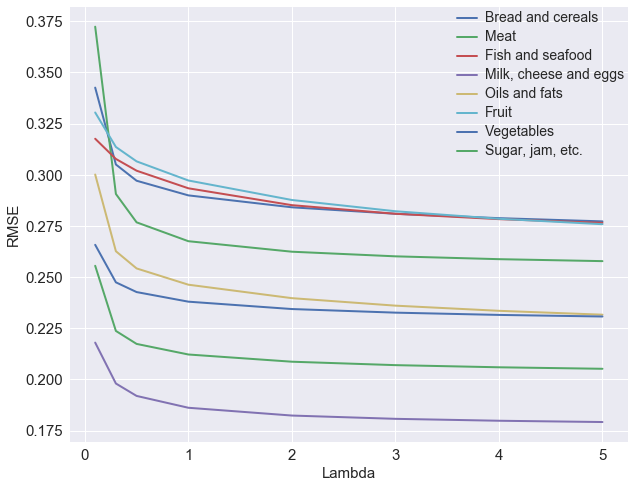

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

alpha_ridge = (1e-1, 3e-1, 5e-1, 1, 2, 3, 4, 5) #Range of possible regularization values
ridge_alpha_results = np.empty([len(filenames),(len(alpha_ridge))])
plt.figure(figsize=(10,8))
#Format
sns.set(style="darkgrid")
sns.color_palette("muted")

def ridge_graph(X, y, alpha):    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    ridger = linear_model.Ridge(random_state=123, alpha=alpha)
    ridger.fit(X_train, y_train)
    y_pred = ridger.predict(X_test)
    error = np.sqrt(mean_squared_error(y_test, y_pred))
    return(error)

for file in range(0,len(filenames)):
    fulldf = pd.read_csv(filenames[file])
    fulldf.fillna(value = 0, inplace = True)
    ydf = fulldf.dlprcs_a
    #Add full competitor's prices/how much the prices have changed since the item's last price change
    ml_reg_vars_add = [col for col in fulldf if col.startswith('tau_')] +\
    [col for col in fulldf if col.startswith('og_')]
    #Divide competitor price variables by each unique item's duration
    Xdf1 = fulldf.loc[:,ml_reg_vars_add].mul(np.array(fulldf.inv_sqrt_duration_lag), axis=0)
    Xdf2 = fulldf.loc[:, lin_reg_vars]
    Xdf = pd.concat([Xdf2,Xdf1], axis=1)
    ridge_reg_vars = Xdf.columns.tolist()
    Xdf = fulldf.loc[:, ridge_reg_vars]
    i = -1
    for alpha in alpha_ridge:
        i += 1
        ridge_alpha_results[file,i] = ridge_graph(Xdf, ydf, alpha)
    plt.plot(alpha_ridge, ridge_alpha_results[file,:], lw=2, label='%s' % (categories[file]))

plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel('Lambda', size=15)
plt.ylabel('RMSE', size=15)
#plt.title('Out of Sample RMSE Vs. Regulation Size (Ridge)', size=15)
plt.legend(loc=0, borderaxespad=0.)
ltext = plt.gca().get_legend().get_texts()
plt.setp(ltext[0], fontsize=14)
plt.setp(ltext[1], fontsize=14)
plt.setp(ltext[2], fontsize=14)
plt.setp(ltext[3], fontsize=14)
plt.setp(ltext[4], fontsize=14)
plt.setp(ltext[5], fontsize=14)
plt.setp(ltext[6], fontsize=14)
plt.setp(ltext[7], fontsize=14)
plt.show()    

### KNN Graph

In [81]:
#Just Use last DataFrame from above (just need one)
from sklearn.neighbors import kneighbors_graph
from mpl_toolkits.mplot3d import Axes3D
fulldf = pd.read_csv(filenames[2])
fulldf.fillna(value = 0, inplace = True)

#Random sample of food category 118
X = fulldf[['lp_na_lag', 'dlprcs_a_lst', 'sqrt_duration_lag']].loc[0:500,:]
A = kneighbors_graph(X, n_neighbors=5, mode='connectivity')

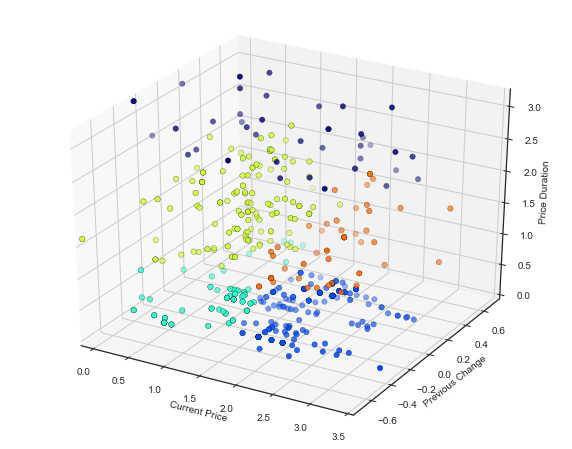

In [117]:
from sklearn.cluster import AgglomerativeClustering
ward = AgglomerativeClustering(n_clusters=5, connectivity=A,
                               linkage='ward').fit(X)
label = ward.labels_

fig = plt.figure(figsize=(10,8))
sns.set(style="white")
ax = fig.gca(projection='3d')

for l in np.unique(label):
    ax.scatter(X.iloc[label == l, 0], X.iloc[label == l, 1], X.iloc[label == l, 2],
               color=plt.cm.jet(float(l) / np.max(label + 1)),
               s=30, edgecolor='k')

ax.set_xlim(-0.1, 3.5)
ax.set_ylim(-0.75,0.75)
ax.set_zlim(0,3.2)
ax.set_xlabel('Current Price', fontsize=10)
ax.set_ylabel('Previous Change', fontsize=10)
ax.set_zlabel('Price Duration', fontsize=10)

### Random Forest Figure

[0, 1, 0, 1]

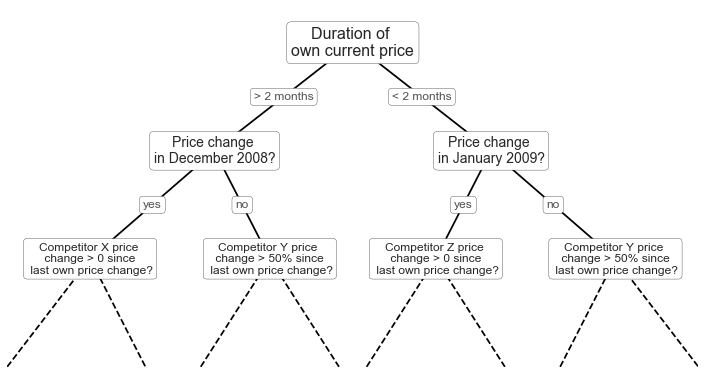

In [18]:
#Random forest (need to get output)
fig = plt.figure(figsize=(12, 5))
ax = fig.add_axes([0, 0, 0.8, 1], frameon=False, xticks=[], yticks=[])
#ax.set_title('Example Decision Tree: Animal Classification', size=24)

def text(ax, x, y, t, size=20, **kwargs):
    ax.text(x, y, t,
            ha='center', va='center', size=size,
            bbox=dict(boxstyle='round', ec='k', fc='w'), **kwargs)

text(ax, 0.5, 0.9, "Duration of \nown current price", 16)
text(ax, 0.3, 0.6, "No price change \nin December 2008?", 14)
text(ax, 0.7, 0.6, "No price change \nin January 2009?", 14)
text(ax, 0.12, 0.3, "Competitor X price \n change > 0 since \n last own price change?", 12)
text(ax, 0.38, 0.3, "Competitor Y price \n change > 50% since \n last own price change?", 12)
text(ax, 0.62, 0.3, "Competitor Z price \n change > 0 since \n last own price change?", 12)
text(ax, 0.88, 0.3, "Competitor Y price \n change > 50% since \n last own price change?", 12)

text(ax, 0.4, 0.75, "> 2 months", 12, alpha=0.8)
text(ax, 0.6, 0.75, "< 2 months", 12, alpha=0.8)

text(ax, 0.21, 0.45, "yes", 12, alpha=0.8)
text(ax, 0.34, 0.45, "no", 12, alpha=0.8)

text(ax, 0.66, 0.45, "yes", 12, alpha=0.8)
text(ax, 0.79, 0.45, "no", 12, alpha=0.8)

ax.plot([0.3, 0.5, 0.7], [0.6, 0.9, 0.6], '-k')
ax.plot([0.12, 0.3, 0.38], [0.3, 0.6, 0.3], '-k')
ax.plot([0.62, 0.7, 0.88], [0.3, 0.6, 0.3], '-k')
ax.plot([0.0, 0.12, 0.20], [0.0, 0.3, 0.0], '--k')
ax.plot([0.28, 0.38, 0.48], [0.0, 0.3, 0.0], '--k')
ax.plot([0.52, 0.62, 0.72], [0.0, 0.3, 0.0], '--k')
ax.plot([0.8, 0.88, 1.0], [0.0, 0.3, 0.0], '--k')
ax.axis([0, 1, 0, 1])

#fig.savefig('figures/05.08-decision-tree.png')